# I94 Immigration Data Pipeline
### Data Engineering Capstone Project

#### Project Summary
The objective of this project is to create an ETL pipeline for I94 immigration, global temperatures and US demographics datasets to form an analytics database on immigration events over time. The resulting database will enable analysis on externalities within non-US countries as well as US states which could deliver insight on some of the less obvious factors surrounding immigration to the US.

The project follows the following steps:

- Step 1: Scope the Project and Gather Data
- Step 2: Explore and Assess the Data
- Step 3: Define the Data Model
- Step 4: Run ETL to Model the Data
- Step 5: Complete Project Write Up

In [3]:
pip install boto3

     -------------------------------------- 132.7/132.7 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 79.6/79.6 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 10.3/10.3 MB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Print the Hadoop version
print(spark.sparkContext.getConf().get('spark.hadoop.version'))

# Stop the SparkSession
spark.stop()

None


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt
import numpy as np
from itertools import chain

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import create_map, lit, monotonically_increasing_id
from pyspark.sql.types import *


import requests
requests.packages.urllib3.disable_warnings()

from IPython.display import Image
from IPython.core.display import HTML 


In [2]:
os.environ['JAVA_HOME'] = "C:\Program Files\AdoptOpenJDK\jre-8.0.252.09-hotspot"
os.environ['SPARK_HOME'] = "E:\Anaconda\Lib\site-packages\pyspark"
os.environ['HADOOP_HOME'] = "E:\Anaconda\Lib\site-packages\pyspark"
os.environ["PYSPARK_PYTHON"] = "python"


In [3]:
spark = SparkSession.builder\
                    .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
                    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.2")\
                    .config("C:/Users/david/Capstone/home/SparkSession/config.properties")\
                    .getOrCreate()

In [ ]:
#                    .config("spark.network.timeout","120000s")\
#                    .config("spark.executor.heartbeatInterval","36000s")\

### Step 1: Scope the Project and Gather Data

#### Scope 

Spark will be used to load the data into dataframes, clean said dataframes, and execute our ETL pipeline to create our final data model. Along the way, we will be using tools like Pandas and Seaborn to help visualize our data and sniff out missing values, problematic datatypes, and other potential obstacles.

Once data is sufficiently cleaned, it will be written to parquet files and stored in an output folder.

<br/>

#### Description of our core data
Our data comes from the US National Tourism and Trade Office. Historically, all foreign visitors coming into the USA via air or sea were subject to an examination by the Customs Border Protection (CBP) officer after which they would be issued either a passport admission stamp or a small white card called the I-94 form. This form contains precisely the data which we are basing our data model on.

Immigration data is in parquet format (converted from SAS data using a third-party Spark package - spark-sas7bdat).

### IMMIGRATION DATA

In [4]:
immigration_file = "E:\\Udacity D-Eng\\Capstone\\home\\sas_data\\*.parquet"
df_immigration =spark.read.parquet(immigration_file)

In [5]:
df_immigration_count = df_immigration.count()
print(df_immigration_count)

3096313


### WORLD TEMPERATURE DATA

In [5]:
temperature_file = "C:\\Users\\david\\Capstone\\home\\temperature_data"
df_temperature = spark.read.csv(temperature_file, header=True, inferSchema=True)

In [7]:
df_temperature.limit(5).show()

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+



In [8]:
df_temp_count = df_temperature.count()
print(df_temp_count)

8599212


### US CITIES DEMOGRAPHICS DATA

In [6]:
demographics_file = "us-cities-demographics.csv"
df_demographics = spark.read.csv(demographics_file, inferSchema=True, header=True, sep=';')

In [10]:
df_demographics.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [11]:
df_demo_count = df_demographics.count()
print(df_demo_count)

2891


### AIRPORT CODES DATA

In [7]:
airport_file = 'airport-codes_csv.csv'
df_airport_codes = spark.read.csv(airport_file, header=True, inferSchema=True)
df_airport_codes = df_airport_codes.filter(df_airport_codes.iso_country=='US')

In [13]:
df_airport_codes.limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


### Data Exploration & Cleaning

#### 1. Immigration Data

In [14]:
imm_nan_count = df_immigration.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_immigration.columns]).toPandas()

In [15]:
nan_perc_df = (imm_nan_count/df_immigration_count)*100
nan_perc_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007719,4.928184,4.600859,...,99.98734,4.470769,0.025902,0.015405,13.379429,96.327632,2.700857,0.0,0.631364,0.0


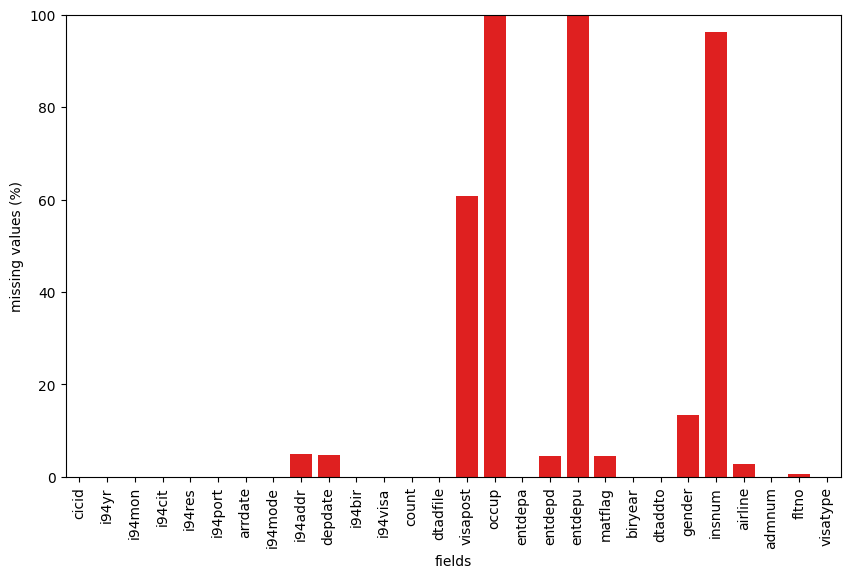

In [16]:
plt.figure(figsize=(10,6))
bar = sns.barplot(
    data= nan_perc_df,
    color='r'
)
bar.set(xlabel='fields', ylabel='missing values (%)',ylim=(0,100))
bar.tick_params(axis='x', rotation=90)

In [17]:
# Isolating column names which are missing 80% or more data 
drop_cols = []
for (colname,colval) in nan_perc_df.items():
    if colval.values >= 80:
        drop_cols.append(colname)

print(drop_cols)

['occup', 'entdepu', 'insnum']


##### Converting SAS dates

In [18]:
get_date = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
df_immigration =  df_immigration.withColumn("arrdate", get_date(df_immigration.arrdate)) \
                                 .withColumn("depdate", get_date(df_immigration.depdate))

In [42]:
# Retrieving key-value pairs from SAS Labels Descriptions file
with open('./I94_SAS_Labels_Descriptions.SAS') as f:
    f_content = f.read()
    f_content = f_content.replace('\t', '')
        
def code_mapper(file, idx):
    f_content2 = f_content[f_content.index(idx):]
    f_content2 = f_content2[:f_content2.index(';')].split('\n')
    f_content2 = [i.replace("'", "") for i in f_content2]
    dic = [i.split('=') for i in f_content2[1:]]
    dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
    return dic    

i94cit_res = code_mapper(f_content, "i94cntyl")
i94mode = code_mapper(f_content, "i94model")
i94addr = code_mapper(f_content, "i94addrl")
i94visa = {'1':'Business',
'2': 'Pleasure',
'3' : 'Student'}

(1/4) Creating label fields based on I-94 IDs...


In [43]:
# Converting id fields to integers for value mapping
df_immigration = df_immigration.withColumn("cicid",df_immigration.cicid.cast("int")) \
                                .withColumn("i94yr",df_immigration.i94yr.cast("int")) \
                                .withColumn("i94mon",df_immigration.i94mon.cast("int")) \
                                .withColumn("i94cit",df_immigration.i94cit.cast("int")) \
                                .withColumn("i94res",df_immigration.i94res.cast("int")) \
                                .withColumn("i94mode",df_immigration.i94mode.cast("int")) \
                                .withColumn("i94bir",df_immigration.i94bir.cast("int")) \
                                .withColumn("i94visa",df_immigration.i94visa.cast("int"))

In [44]:
# Creating map literals to create value columns based on key mappings
mapping_i94cit_res = create_map([lit(x) for x in chain(*i94cit_res.items())])
mapping_i94mode = create_map([lit(x) for x in chain(*i94mode.items())])
mapping_i94addr = create_map([lit(x) for x in chain(*i94addr.items())])
mapping_i94visa = create_map([lit(x) for x in chain(*i94visa.items())])

# Adding columns to dataframe based on I-94 codes and their mappings
df_immigration =  df_immigration.withColumn("i94cit_value", mapping_i94cit_res.getItem(col("i94cit"))) \
                                .withColumn("i94res_value", mapping_i94cit_res.getItem(col("i94res"))) \
                                .withColumn("i94mode_value", mapping_i94mode.getItem(col("i94mode"))) \
                                .withColumn("i94addr_value", mapping_i94addr.getItem(col("i94addr"))) \
                                .withColumn("i94visa_value", mapping_i94visa.getItem(col("i94visa"))) 

E:\Anaconda\lib\site-packages\pyspark\sql\column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


##### Creating the clean_immigration_data function

In [9]:
def clean_immigration_data(df_immigration):
    """
    Inputs: I-94 immigration Spark dataframe
    
    This function takes in the pre-loaded immigration dataframe and performs a few data cleaning tasks.
    
    1. Maps key-value pairs from the SAS Labels Description file to I-94 codes and inserts them as new columns
    2. Drops incomplete fields
    3. Drops any rows with duplicate `cicid` values
    4. Converts SAS dates to datetype
    """
    
    # Retrieving key-value pairs from SAS Labels Descriptions file
    print('(1/4) Creating label fields based on I-94 IDs...')
    with open('./I94_SAS_Labels_Descriptions.SAS') as f:
        f_content = f.read()
        f_content = f_content.replace('\t', '')
        
    def code_mapper(file, idx):
        f_content2 = f_content[f_content.index(idx):]
        f_content2 = f_content2[:f_content2.index(';')].split('\n')
        f_content2 = [i.replace("'", "") for i in f_content2]
        dic = [i.split('=') for i in f_content2[1:]]
        dic = dict([i[0].strip(), i[1].strip()] for i in dic if len(i) == 2)
        return dic    

    i94cit_res = code_mapper(f_content, "i94cntyl")
    i94mode = code_mapper(f_content, "i94model")
    i94addr = code_mapper(f_content, "i94addrl")
    i94visa = {'1':'Business',
    '2': 'Pleasure',
    '3' : 'Student'}


    # Converting id fields to integers for value mapping
    df_immigration = df_immigration.withColumn("cicid",df_immigration.cicid.cast("int")) \
                                        .withColumn("i94yr",df_immigration.i94yr.cast("int")) \
                                        .withColumn("i94mon",df_immigration.i94mon.cast("int")) \
                                        .withColumn("i94cit",df_immigration.i94cit.cast("int")) \
                                        .withColumn("i94res",df_immigration.i94res.cast("int")) \
                                        .withColumn("i94mode",df_immigration.i94mode.cast("int")) \
                                        .withColumn("i94bir",df_immigration.i94bir.cast("int")) \
                                        .withColumn("i94visa",df_immigration.i94visa.cast("int"))


    # Creating map literals to create value columns based on key mappings
    mapping_i94cit_res = create_map([lit(x) for x in chain(*i94cit_res.items())])
    mapping_i94mode = create_map([lit(x) for x in chain(*i94mode.items())])
    mapping_i94addr = create_map([lit(x) for x in chain(*i94addr.items())])
    mapping_i94visa = create_map([lit(x) for x in chain(*i94visa.items())])

    # Adding columns to dataframe based on I-94 codes and their mappings
    df_immigration =  df_immigration.withColumn("i94cit_value", mapping_i94cit_res.getItem(col("i94cit"))) \
                                    .withColumn("i94res_value", mapping_i94cit_res.getItem(col("i94res"))) \
                                    .withColumn("i94mode_value", mapping_i94mode.getItem(col("i94mode"))) \
                                    .withColumn("i94addr_value", mapping_i94addr.getItem(col("i94addr"))) \
                                    .withColumn("i94visa_value", mapping_i94visa.getItem(col("i94visa"))) 

    print('(2/4) Converting SAS dates to date type...')    
    # Create UDF to convert SAS dates to date type
    get_date = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    df_immigration =  df_immigration.withColumn("arrdate", get_date(df_immigration.arrdate)) \
                                    .withColumn("depdate", get_date(df_immigration.depdate))
    
    print('(3/4) Dropping fields with mostly incomplete data...')        
    # Dropping fields with mostly incomplete data
    drop_cols = ['occup', 'entdepu', 'insnum']
    df_immigration = df_immigration.drop(*drop_cols)

    print('(4/4) Dropping fields with mostly incomplete data...')            
    # Dropping rows with duplicate cicid values
    df_immigration = df_immigration.dropDuplicates(['cicid'])
    cleaned_df_immigration = df_immigration.dropna(how='all', subset=['cicid'])

    print('Done!')
    
    return cleaned_df_immigration

#### 2. Temperature Data

In [20]:
df_temp_castdt = df_temperature.withColumn("dt",col("dt").cast(StringType()))
temp_nan_count = df_temp_castdt.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_temp_castdt.columns]).toPandas()

In [21]:
nan_perc_temp = (temp_nan_count/df_temp_count)*100
nan_perc_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,0.0,4.234458,4.234458,0.0,0.0,0.0,0.0


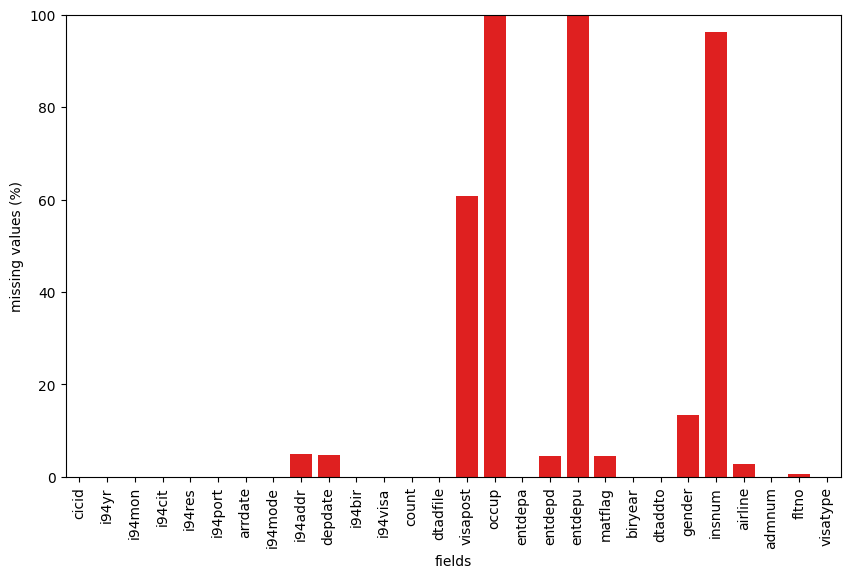

In [22]:
plt.figure(figsize=(10,6))
bar = sns.barplot(
    data= nan_perc_df,
    color='r'
)
bar.set(xlabel='fields', ylabel='missing values (%)',ylim=(0,100))
bar.tick_params(axis='x', rotation=90)

In [23]:
# checking years available to determine level of aggregation
df_temperature.createOrReplaceTempView("df_temperature")
df_temperature_max_year = spark.sql("""
                            select max(year(dt))
                            from df_temperature
    """)
df_temperature_max_year.show()

+-------------+
|max(year(dt))|
+-------------+
|         2013|
+-------------+



*Our data has incongruent dates between the temperatures dataset and the immigrants dataset. We will therefore aggregate our average temperatures by country.*

##### Creating the clean_temperature_data function

In [10]:
def clean_temperature_data(df_temperature):
    """
    Inputs: Country temperatures Spark dataframe
    
    This function takes in the pre-loaded temperatures dataframe and drops (a) duplicate rows,
    and (b) rows with missing average temperatures.
    """
    df_temperature = df_temperature.dropDuplicates()
    cleaned_df_temperature = df_temperature.na.drop(subset=["AverageTemperature"])
    
    print('Done!')
    return cleaned_df_temperature

#### 3. Demographics Data

In [25]:
imm_nan_count = df_demographics.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_demographics.columns]).toPandas()

In [26]:
nan_perc_df = (imm_nan_count/df_immigration_count)*100
nan_perc_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,0.0,0.0,0.0,0.000097,0.000097,0.0,0.00042,0.00042,0.000517,0.0,0.0,0.0


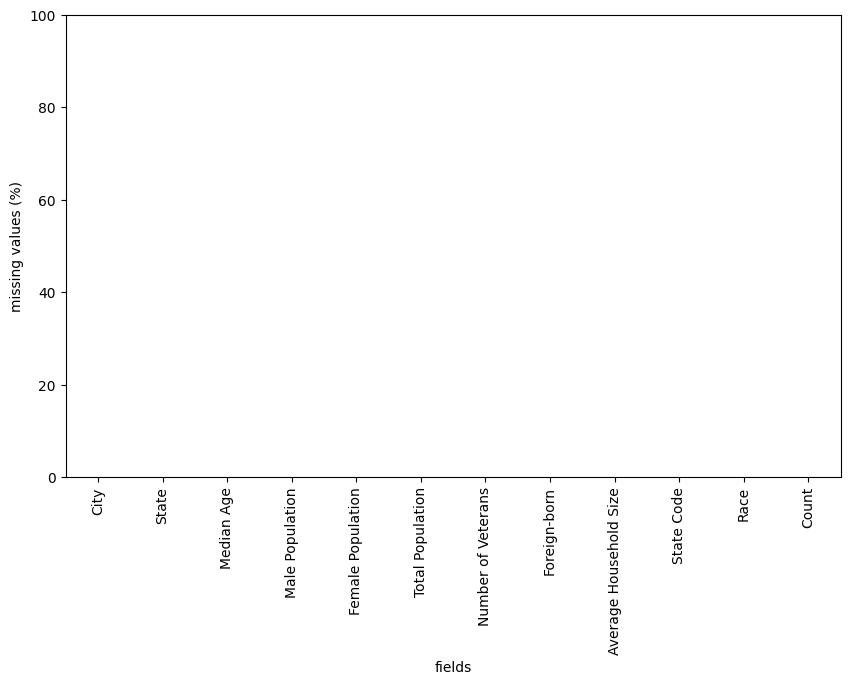

In [27]:
plt.figure(figsize=(10,6))
bar = sns.barplot(
    data= nan_perc_df,
    color='r'
)
bar.set(xlabel='fields', ylabel='missing values (%)',ylim=(0,100))
bar.tick_params(axis='x', rotation=90)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

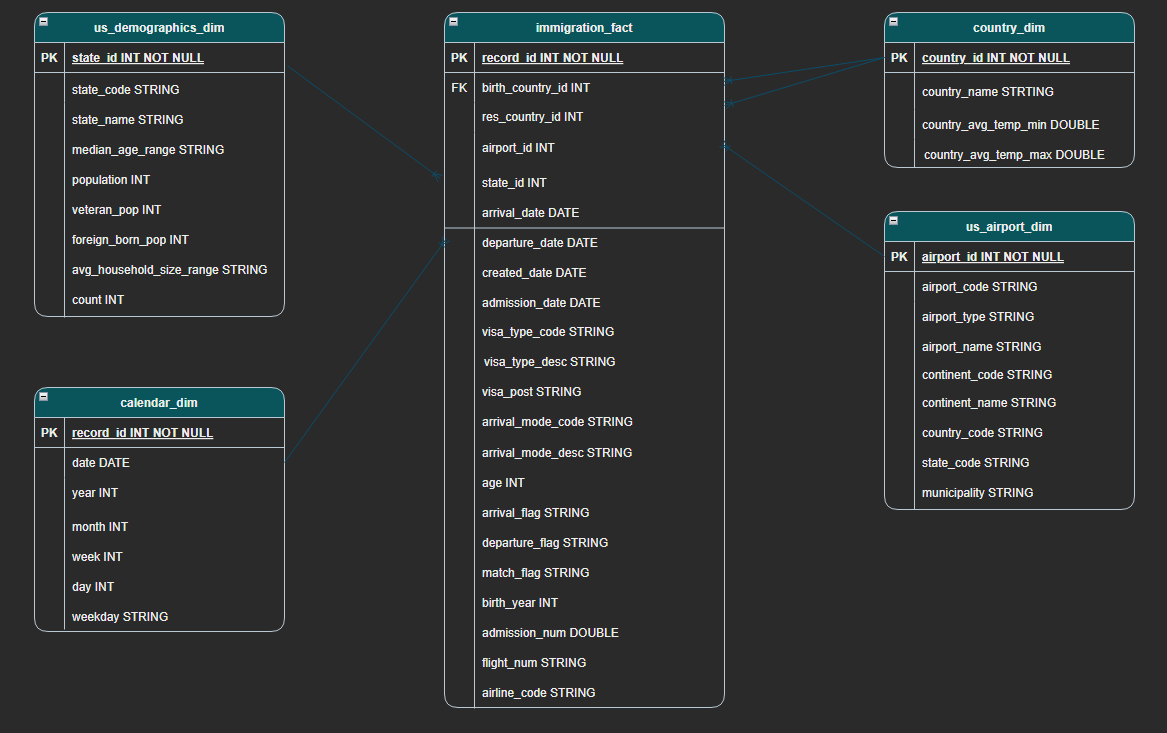

In [28]:
Image(filename = "ERD.png", width=1167, height=733)

#### The Fact Table
Our immigration fact table was left at its most granular level possible, allowing us to have flexibility should we want to create a proper data warehouse further down the line with different levels of aggregation. As such, our data model can drill down to the date-time level for each individual immigrant. Tables with values at city-level granularity were aggregated to state-level or higher to enable joins to our fact table and avoid exploding our data unnecessarily.

#### The Dimension Tables
Our dimension tables include demographic information for each US city, average temperatures for various countries, and descriptive airport information, all of which can be joined to our fact table's foreign keys. We also have a calendar table (derived from the SAS dates in our immigration data) which will allow us to filter and group by various time dimensions with ease.

#### Why?
The purpose of this data model is to enable users to analyse US immigration data with added context coming from the average temperature of resident countries at the time of departure as well as demographic information of the US states that individuals are immigrating to.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

The pipeline steps are as follows:

- Load in the datasets
- Clean datasets
    - check for missing values
    - check for duplicates
- Create dimension tables based on I94 immigration data
    - Clean the I94 Immigration data to create Spark dataframe for each month
    - Create calendar dimension table
- Create country dimension table
- Create immigration fact table
- Create dimesion table based on demographics data
    - Create demographic dimension table

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model 
Build the data pipelines to create the data model.

*Note: 4.1 contains segmented code for Pandas dataframe samples of the final tables. Skip to 4.2 for final function definition.*

In [29]:
df_immigration.createOrReplaceTempView("df_immigration")
calendar_dim = spark.sql("""
                            select distinct
                                arrdate as date,
                                year(arrdate) as year,
                                month(arrdate) as month,
                                weekofyear(arrdate) as week,
                                dayofyear(arrdate) as day,
                                dayofweek(arrdate) as weekday
                            from df_immigration
    """)

In [30]:
calendar_dim.limit(5).toPandas()

,date,year,month,week,day,weekday
0,2016-04-10,2016,4,14,101,1
1,2016-04-27,2016,4,17,118,4
2,2016-04-08,2016,4,14,99,6
3,2016-04-01,2016,4,13,92,6
4,2016-04-09,2016,4,14,100,7


In [31]:
#storing row count for data quality checks
count_calendar_dim_df = calendar_dim.count()

In [32]:
df_country = df_temperature.select(col("Country")).distinct()
df_temperature.createOrReplaceTempView("df_temperature")
df_country.createOrReplaceTempView("df_country")
country_dim = spark.sql("""
                            select
                                row_number() over (ORDER BY "c.Country") as country_id,
                                c.Country as country_name,
                                min(t.AverageTemperature) as country_avg_temp_min,
                                max(t.AverageTemperature) as country_avg_temp_max
                            from df_country c
                            left join df_temperature t on c.Country = t.Country
                            group by c.Country

    """)

In [33]:
country_dim.limit(5).toPandas()

,country_id,country_name,country_avg_temp_min,country_avg_temp_max
0,1,Chad,22.187,33.073
1,2,Guyana,23.087,29.254
2,3,Paraguay,12.753,29.509
3,4,Russia,-42.704,29.253
4,5,Senegal,18.768,31.823


In [34]:
#storing row count for data quality checks
count_country_dim_df = country_dim.count()

In [35]:
df_airport_codes.createOrReplaceTempView("df_airport_codes")
us_airport_dim = spark.sql("""
                            select
                                row_number() over (order by "iata_code") as airport_id,
                                iata_code as airport_code,
                                type as airport_type,
                                name as airport_name,
                                continent as continent_code,
                                case 
                                    when continent = 'NA' then 'North America'
                                    when continent = 'AF' then 'Africa'
                                    when continent = 'AN' then 'Antarctica'
                                    when continent = 'AS' then 'Asia'
                                    when continent = 'EU' then 'Europe'
                                    when continent = 'OC' then 'Oceania'
                                    when continent = 'SA' then 'South America'
                                end as continent_name,
                                iso_country as country_code,
                                right(iso_region,2) as state_code,
                                municipality
                            from df_airport_codes
    """)

In [36]:
us_airport_dim.limit(5).toPandas()

,airport_id,airport_code,airport_type,airport_name,continent_code,continent_name,country_code,state_code,municipality
0,1,None,heliport,Total Rf Heliport,NA,North America,US,PA,Bensalem
1,2,None,small_airport,Aero B Ranch Airport,NA,North America,US,KS,Leoti
2,3,None,small_airport,Lowell Field,NA,North America,US,AK,Anchor Point
3,4,None,small_airport,Epps Airpark,NA,North America,US,AL,Harvest
4,5,None,closed,Newport Hospital & Clinic Heliport,NA,North America,US,AR,Newport


In [37]:
#storing row count for data quality checks
count_airport_dim_df = us_airport_dim.count()

In [38]:
df_demographics.createOrReplaceTempView("df_demographics")
us_demographics_dim = spark.sql("""
                                select
                                    row_number() over (order by `State Code`) as state_id,
                                    `State Code` as state_code,
                                    State as state_name,
                                    concat(cast(min(`Median Age`) as string)," - ",cast(max(`Median Age`) as string)) as median_age_range,
                                    sum(`Total Population`) as population,
                                    sum(`Number of Veterans`) as veteran_pop,
                                    sum(`Foreign-born`) as foreign_born_pop,
                                    concat(cast(min(`Average Household Size`) as string)," - ",cast(max(`Average Household Size`) as string)) as avg_household_size_range,
                                    sum(Count) as count
                                from df_demographics
                                group by 
                                    `State Code`,
                                    State
    """)

In [39]:
us_demographics_dim.limit(5).toPandas()

,state_id,state_code,state_name,median_age_range,population,veteran_pop,foreign_born_pop,avg_household_size_range,count
0,1,AK,Alaska,32.2 - 32.2,1493475,137460,166290,2.77 - 2.77,336228
1,2,AL,Alabama,29.1 - 38.9,5163306,352896,252541,2.18 - 2.67,1096154
2,3,AR,Arkansas,27.1 - 36.6,2882889,154390,307753,2.28 - 3.04,643597
3,4,AZ,Arizona,23.9 - 46.9,22497710,1322525,3411565,2.17 - 3.44,5754881
4,5,CA,California,26.3 - 47.6,123444353,4617022,37059662,2.0 - 4.78,31753718


In [40]:
#storing row count for data quality checks
count_demographics_dim_df = us_demographics_dim.count()

In [45]:
us_airport_dim.createOrReplaceTempView("us_airport_dim")
us_demographics_dim.createOrReplaceTempView("us_demographics_dim")
country_dim.createOrReplaceTempView("country_dim")
df_immigration.createOrReplaceTempView("df_immigration")
immigration_fact = spark.sql("""
            select 
                birth.country_id as birth_country_id,
                res.country_id as res_country_id,
                p.airport_id,
                d.state_id,
                arrdate as arrival_date,
                depdate as departure_date,
                dtadfile as created_date,
                dtaddto as admission_date,
                i94visa as visa_type_code,
                i94visa_value as visa_type_desc,
                visapost as visa_post,
                i94mode as arrival_mode_code,
                i94mode_value as arrival_mode_desc,
                i94bir as age,
                entdepa as arrival_flag,
                entdepd as departure_flag,
                matflag as match_flag,
                biryear as birth_year,
                admnum as admission_num,
                fltno as flight_num,
                airline airline_code
            from df_immigration i
            left join country_dim birth on lower(i.i94cit_value)=lower(birth.country_name)
            left join country_dim res on lower(i.i94cit_value)=lower(res.country_name)
            left join us_airport_dim p on i.i94port = p.airport_code
            left join us_demographics_dim d on i.i94addr = d.state_code
    """)

In [46]:
immigration_fact.limit(20).toPandas()

,birth_country_id,res_country_id,airport_id,state_id,arrival_date,departure_date,created_date,admission_date,visa_type_code,visa_type_desc,...,arrival_mode_code,arrival_mode_desc,age,arrival_flag,departure_flag,match_flag,birth_year,admission_num,flight_num,airline_code
0,NaN,NaN,NaN,5.0,2016-04-30,2016-05-08,20160430,10292016,1,Business,...,1,Air,40,G,O,M,1976.0,9.495387e+10,00011,QF
1,NaN,NaN,NaN,34.0,2016-04-30,2016-05-17,20160430,10292016,1,Business,...,1,Air,32,G,O,M,1984.0,9.495562e+10,00007,VA
2,NaN,NaN,NaN,48.0,2016-04-30,2016-05-08,20160430,10292016,1,Business,...,1,Air,29,G,O,M,1987.0,9.495641e+10,00040,DL
3,NaN,NaN,NaN,48.0,2016-04-30,2016-05-14,20160430,10292016,1,Business,...,1,Air,29,G,O,M,1987.0,9.495645e+10,00040,DL
4,NaN,NaN,NaN,48.0,2016-04-30,2016-05-14,20160430,10292016,1,Business,...,1,Air,28,G,O,M,1988.0,9.495639e+10,00040,DL
5,NaN,NaN,NaN,12.0,2016-04-30,2016-05-05,20160430,10292016,2,Pleasure,...,1,Air,57,G,O,M,1959.0,9.498180e+10,00010,NZ
6,NaN,NaN,NaN,12.0,2016-04-30,2016-05-12,20160430,10292016,2,Pleasure,...,1,Air,66,G,O,M,1950.0,9.497969e+10,00010,NZ
7,NaN,NaN,NaN,12.0,2016-04-30,2016-05-12,20160430,10292016,2,Pleasure,...,1,Air,41,G,O,M,1975.0,9.497975e+10,00010,NZ
8,NaN,NaN,14631.0,10.0,2016-04-30,2016-05-07,20160430,10292016,2,Pleasure,...,1,Air,27,G,O,M,1989.0,9.497325e+10,00028,NZ
9,NaN,NaN,NaN,5.0,2016-04-30,2016-05-07,20160430,10292016,2,Pleasure,...,1,Air,26,G,O,M,1990.0,9.501355e+10,00002,NZ


In [47]:
#storing row count for data quality checks
count_immigration_fact_df = immigration_fact.count()

#### 4.2 Creating functions that write to parquet database

In [11]:
def process_tables(df_temperature,df_airport_codes,df_demographics,df_immigration,output_path):
    
    df_immigration.createOrReplaceTempView("df_immigration")
    calendar_dim = spark.sql("""
                                select distinct
                                    arrdate as date,
                                    year(arrdate) as year,
                                    month(arrdate) as month,
                                    weekofyear(arrdate) as week,
                                    dayofyear(arrdate) as day,
                                    dayofweek(arrdate) as weekday
                                from df_immigration
                                """)

    
    df_country = df_temperature.select(col("Country")).distinct()
    df_temperature.createOrReplaceTempView("df_temperature")
    df_country.createOrReplaceTempView("df_country")
    country_dim = spark.sql("""
                                select
                                    row_number() over (ORDER BY "c.Country") as country_id,
                                    c.Country as country_name,
                                    min(t.AverageTemperature) as country_avg_temp_min,
                                    max(t.AverageTemperature) as country_avg_temp_max
                                from df_country c
                                left join df_temperature t on c.Country = t.Country
                                group by c.Country

                                """)


    df_airport_codes.createOrReplaceTempView("df_airport_codes")
    us_airport_dim = spark.sql("""
                                select
                                    row_number() over (order by "iata_code") as airport_id,
                                    iata_code as airport_code,
                                    type as airport_type,
                                    name as airport_name,
                                    continent as continent_code,
                                    case 
                                        when continent = 'NA' then 'North America'
                                        when continent = 'AF' then 'Africa'
                                        when continent = 'AN' then 'Antarctica'
                                        when continent = 'AS' then 'Asia'
                                        when continent = 'EU' then 'Europe'
                                        when continent = 'OC' then 'Oceania'
                                        when continent = 'SA' then 'South America'
                                    end as continent_name,
                                    iso_country as country_code,
                                    right(iso_region,2) as state_code,
                                    municipality
                                from df_airport_codes
                                """)


    df_demographics.createOrReplaceTempView("df_demographics")
    us_demographics_dim = spark.sql("""
                                    select
                                        row_number() over (order by `State Code`) as state_id,
                                        `State Code` as state_code,
                                        State as state_name,
                                        concat(cast(min(`Median Age`) as string)," - ",cast(max(`Median Age`) as string)) as median_age_range,
                                        sum(`Total Population`) as population,
                                        sum(`Number of Veterans`) as veteran_pop,
                                        sum(`Foreign-born`) as foreign_born_pop,
                                        concat(cast(min(`Average Household Size`) as string)," - ",cast(max(`Average Household Size`) as string)) as avg_household_size_range,
                                        sum(Count) as count
                                    from df_demographics
                                    group by 
                                        `State Code`,
                                        State
                                    """)
     
    us_airport_dim.createOrReplaceTempView("us_airport_dim")
    us_demographics_dim.createOrReplaceTempView("us_demographics_dim")
    country_dim.createOrReplaceTempView("country_dim")
    df_immigration.createOrReplaceTempView("df_immigration")
    immigration_fact = spark.sql("""
                                select 
                                    birth.country_id as birth_country_id,
                                    res.country_id as res_country_id,
                                    p.airport_id,
                                    d.state_id,
                                    arrdate as arrival_date,
                                    depdate as departure_date,
                                    dtadfile as created_date,
                                    dtaddto as admission_date,
                                    i94visa as visa_type_code,
                                    i94visa_value as visa_type_desc,
                                    visapost as visa_post,
                                    i94mode as arrival_mode_code,
                                    i94mode_value as arrival_mode_desc,
                                    i94bir as age,
                                    entdepa as arrival_flag,
                                    entdepd as departure_flag,
                                    matflag as match_flag,
                                    biryear as birth_year,
                                    admnum as admission_num,
                                    fltno as flight_num,
                                    airline airline_code
                                from df_immigration i
                                left join country_dim birth on lower(i.i94cit_value)=lower(birth.country_name)
                                left join country_dim res on lower(i.i94cit_value)=lower(res.country_name)
                                left join us_airport_dim p on i.i94port = p.airport_code
                                left join us_demographics_dim d on i.i94addr = d.state_code
                                """)
    immigration_fact = immigration_fact.withColumn("record_id", monotonically_increasing_id())
    
    print('(1/5) Creating calendar_dim...')    
    calendar_dim.write.parquet(output_path + "calendar_dim", partitionBy=['year', 'month', 'week'], mode="overwrite")
    
    print('(2/5) Creating us_demographics_dim...')   
    us_demographics_dim.write.parquet(output_path + "us_demographics_dim", partitionBy='state_code', mode="overwrite")

    print('(3/5) Creating us_airport_dim...')   
    us_airport_dim.write.parquet(output_path + "us_airport_dim", mode="overwrite")
    
    print('(4/5) Creating country_dim...')   
    country_dim.write.parquet(output_path + "country_dim", mode="overwrite")

    print('(5/5) Creating immigration_fact...')  
    immigration_fact.write.parquet(output_path + "immigration_fact", mode="overwrite")
    
    print('Done!')

### Running the pipeline
##### 1. Cleaning

In [12]:
df_immigration = clean_immigration_data(df_immigration)

(1/4) Creating label fields based on I-94 IDs...
(2/4) Converting SAS dates to date type...
(3/4) Dropping fields with mostly incomplete data...
(4/4) Dropping fields with mostly incomplete data...
Done!


E:\Anaconda\lib\site-packages\pyspark\sql\column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [13]:
df_temperature = clean_temperature_data(df_temperature)

Done!


##### 2. Creating the Parquet Database

In [14]:
output_path = "output/"

In [15]:
process_tables(df_temperature, df_airport_codes, df_demographics, df_immigration, output_path)

(1/5) Creating calendar_dim...
(2/5) Creating us_demographics_dim...
(3/5) Creating us_airport_dim...
(4/5) Creating country_dim...
(5/5) Creating immigration_fact...
Done!


#### 4.2 Data Quality Checks
The data quality checks below verify whether rows were successfully written to our parquet database.
 
Run Quality Checks

Check 1.

In [16]:
# Check for records and return count
df_list = ['calendar_dim','country_dim','us_demographics_dim','us_airport_dim','immigration_fact']

for table in df_list:
    parquet_count = spark.read.parquet(f"output/{table}/").count()
    if parquet_count != 0:
        print(f"Data quality check for {table} was successful with {parquet_count} rows.\n")
    else:
        print(f"{table} has 0 rows\n")

Data quality check for calendar_dim was successful with 30 rows.

Data quality check for country_dim was successful with 159 rows.

Data quality check for us_demographics_dim was successful with 49 rows.

Data quality check for us_airport_dim was successful with 22757 rows.

Data quality check for immigration_fact was successful with 3102538 rows.



Check 2.

In [17]:
if spark.read.parquet("output/immigration_fact/").count() > spark.read.parquet("output/immigration_fact/").dropDuplicates(subset=['record_id']).count():
    raise ValueError('immigration_fact primary key field contains duplicates')
else:
    print('Success: immigration_fact primary key field is unique')

Success: immigration_fact primary key field is unique


### 4.3 Data dictionary 

#### immigration_fact
| Field             | Description                                                                             |
|-------------------|-----------------------------------------------------------------------------------------|
| record_id         | Primary key. Unique identifier for each record.                                         |
| birth_country_id  | Foreign key. Unique identifier for birth country of immigrant. Joins to country_dim.    |
| res_country_id    | Foreign key. Unique identifier for resident country of immigrant. Joins to country_dim. |
| airport_id        | Foreign key. Unique identifier for airport. Joins to us_airport_dim.                    |
| state_id          | Foreign key. Unique identifier for US state. Joins to us_demographics_dim.              |
| arrival_date      | Date of arrival to the USA. Can be joined to calendar_dim.                              |
| departure_date    | Date of departure from the USA. Can be joined to calendar_dim.                          |
| created_date      | Date the record was created in the I94 files. Can be joined to calendar_dim.            |
| admission_date    | Date of admission into the USA. Can be joined to calendar_dim                           |
| visa_type_code    | Code which specifies the type of visa.                                                  |
| visa_type_desc    | Immigrant visa type description.                                                        |
| visa_post         | Department of State where visa was issued.                                              |
| arrival_mode_code | Code which specifies the method of arrival (ex. air, land) into USA.                    |
| arrival_mode_desc | Description of arrival mode code.                                                       |
| age               | Age of immigrant in years.                                                              |
| arrival_flag      | Arrival flag - admitted or paroled into the USA.                                        |
| departure_flag    | Departure flag - departed, lost I94, deceased                                           |
| match_flag        | Match flag - match of arrival and departure records                                     |
| birth_year        | Immigrant year of birth                                                                 |
| admission_num     | Associated admission number.                                                            |
| flight_num        | Flight number of the Airline used to travel to USA.                                     |
| airline_code      | Airline used to travel to USA.                                                          |


#### calendar_dim
| Field     | Description                                               |
|-----------|-----------------------------------------------------------|
| date      | Primary key. Unique identifier for each record.           |
| year      | Gregorian calendar year.                                  |
| month     | Gregorian calendar month.                                 |
| week      | Gregorian calendar week.                                  |
| day       | Day of the year.                                          |
| weekday   | Weekday in integer-form where 0 = Monday and 6 = Sunday.  |

#### country_dim
| Field                | Description                                                         |
|----------------------|---------------------------------------------------------------------|
| country_id           | Primary key. Unique identifier for each record (i.e. each country). |
| country_name         | Country name.                                                       |
| country_avg_temp_min | All-time minimum average temperature (monthly).                     |
| country_avg_temp_max | All-time maximum average temperature (monthly).                     |
| continent_code       | Continent code where airport is found.                              |
| continent_name       | Continent name where airport is found.                              |
| country_code         | Country code where airport is found.                                |


#### us_airport_dim
| Field          | Description                                                            |
|----------------|------------------------------------------------------------------------|
| airport_id     | Primary key. Unique identifier for each record (i.e. each US airport). |
| airport_code   | US airport code.                                                       |
| airport_type   | US airport type.                                                       |
| airport_name   | US airport name.                                                       |
| continent_code | Continent code where airport is found.                                 |
| continent_name | Continent name where airport is found.                                 |
| country_code   | Country code where airport is found.                                   |
| state_code     | State code where airport is found.                                     |
| municipality   | Municipality name where airport is found.                              |

#### us_demographics_dim
| Field                    | Description                                                                                                   |
|--------------------------|---------------------------------------------------------------------------------------------------------------|
| state_id                 | Primary key. Unique identifier for each record (i.e. each US state).                                          |
| state_code               | US state code.                                                                                                |
| state_name               | US state name                                                                                                 |
| median_age_range         | Minimum and maximum median age range of cities within US state, separated by a hyphen.                        |
| population               | Total population of US state.                                                                                 |
| veteran_pop              | Total war veteran population of US state.                                                                     |
| foreign_born_pop         | Total war foreign_born population of US state.                                                                |
| avg_household_size_range | Minimum and maximum average household size (in square feet) of cities within US state, separated by a hyphen. |

### Project Write-up

#### Tools/Technologies used
###### Apache spark:
- Capable of handling large volumes of data from disparate sources and various file formats.

###### Seaborn:
- Quick and easy visualizations of our data to help us rapidly understand where it is lacking.

###### Pandas:
- Easy dataframe computations.
- More legible rendering of dataframes for prototyping.

###### Parquet:
- Columnar storage and partitioning of our data allows us to optimize queries for analysis.

<br/>

#### How often should this be updated?
- Given that the current I94 immigration data is updated monthly, this pipeline would ideally be updated monthly so that it is always up to date.

<br/>

#### Hypothetical Scenarios:
The data was increased by 100x:
- Increase parallelization by upping the number of nodes in our Spark cluster. 

The data populates a dashboard that must be updated on a daily basis by 7am every day.
- Incorporate a workflow management platform like Apache Airflow to run data pipelines on a rigid schedule.
- Make use of the Airflow UI for monitoring over time

The database needed to be accessed by 100+ people.
- Move analytics database to a data warehouse such as Amazon Redshift which can handle massive parallel processing.

### Analysis example:

As a proof of concept for the analytical capabilities of this data model, lets investigate whether immigrants tend to flock more towards US states with high foreign-born populations.

1. Reading the data from our parquet files and stored them in Spark dataframes

In [18]:
imm_df_final = spark.read.parquet("output/immigration_fact/")
demog_df_final = spark.read.parquet("output/us_demographics_dim/")

2. Querying our data using Spark SQL

In [19]:
imm_df_final.createOrReplaceTempView("immigration_fact_final")
demog_df_final.createOrReplaceTempView("us_demographics_dim_final")
foreign_born_pop_analysis = spark.sql("""
                                       select 
                                           d.state_code,
                                           count(i.record_id) as immigrant_count,
                                           sum(foreign_born_pop)/sum(population) as foreign_born_pop_perc
                                       from us_demographics_dim_final d
                                       join immigration_fact_final i
                                           on i.state_id = d.state_id
                                        group by state_code
                                        order by immigrant_count desc, foreign_born_pop_perc desc
                                      """)

3. Tabular analysis

In [20]:
foreign_born_pop_analysis.toPandas()

,state_code,immigrant_count,foreign_born_pop_perc
0,FL,621813,0.242851
1,NY,553827,0.350738
2,CA,471197,0.300214
3,HI,168849,0.287193
4,TX,137448,0.205489
5,NV,115207,0.214811
6,IL,82192,0.205762
7,NJ,76573,0.335845
8,MA,70501,0.257458
9,WA,55954,0.176377


Its hard to draw any conclusions in tabular form... lets visualize it.

4. Using Seaborn's regression plot to visualize any correlation

In [21]:
df = foreign_born_pop_analysis.toPandas()

[Text(0.5, 0, 'Foreign Born Population (%)'),
 Text(0, 0.5, 'Total Number of Immigrants')]

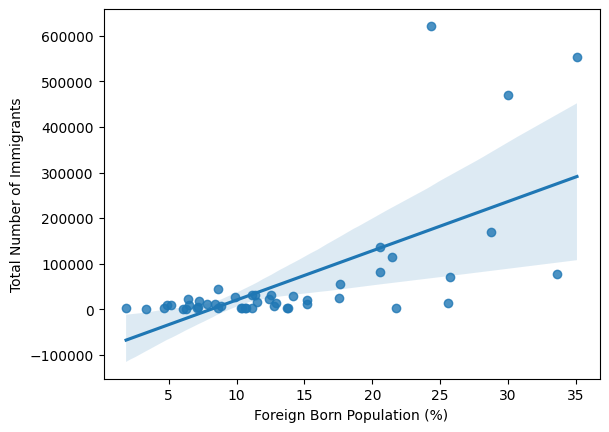

In [22]:
ax = sns.regplot(y=df["immigrant_count"], x=df["foreign_born_pop_perc"]*100, fit_reg=True)
ax.set(xlabel='Foreign Born Population (%)', ylabel='Total Number of Immigrants')


Conclusion: there appears to be a correlation between the number of immigrants towards a US state and the relative amount of foreign-born people living in that state. Evidently, the correlation is rather weak but measurable.